- VADER

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

df = pd.read_csv("../2_data/nvidia_tweets_filtered_cleaned.csv", parse_dates=["created_at"])

# keep tweet text as string type and fill 'NaN' as ""
df["clean_tweet"] = df["clean_tweet"].fillna("").astype(str)

# initialization
sia = SentimentIntensityAnalyzer()

# vader score
df["vader_compound"] = df["clean_tweet"].apply(lambda t: sia.polarity_scores(t)["compound"])

df.to_csv("../2_data/nvidia_tweets_with_sentiment.csv", index=False)


/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_32055/2719823409.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../2_data/nvidia_tweets_filtered_cleaned.csv", parse_dates=["created_at"])


- FinBERT

/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_32055/745818003.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../2_data/nvidia_tweets_filtered_cleaned.csv")
Device set to use cpu


count    513285.000000
mean          0.123205
std           0.418386
min          -1.000000
25%          -0.000445
50%          -0.000004
75%           0.031765
max           1.000000
Name: finbert_score, dtype: float64


<Axes: >

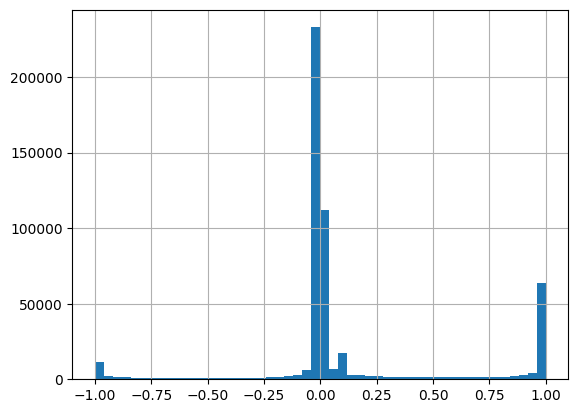

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

df = pd.read_csv("../2_data/nvidia_tweets_filtered_cleaned.csv")
df["clean_tweet"] = df["clean_tweet"].fillna("").astype(str)

# I use my GPU in this case, if you dont have, just delete 'device = 0'
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model     = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert   = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=-1,
    top_k=None
)

# how to compute score
def finbert_continuous_score(text):
    scores = finbert(text[:512])[0]
    score_dict = {item['label'].lower(): item['score'] for item in scores}
    pos_score = score_dict.get('positive', 0.0)
    neg_score = score_dict.get('negative', 0.0)
    return pos_score - neg_score

df["finbert_score"] = df["clean_tweet"].apply(finbert_continuous_score)

print(df["finbert_score"].describe())
df["finbert_score"].hist(bins=50)

In [3]:
df.to_csv("../2_data/finbert_scored_tweets.csv", index=False)

- other BERT (I use distilbert-base-uncased-finetuned-sst-2-english (a BERT pretrained using movie data), to explore the differenced between their performances --> try to prove that finBERT may perform better than other BERT when processing financial text)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# other BERT
tokenizer_other = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model_other = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
other_bert = pipeline("sentiment-analysis", model=model_other, tokenizer=tokenizer_other, device=0)

def other_bert_score(text):
    out = other_bert(text[:512])[0]
    return float(out["score"]) if out["label"] == "POSITIVE" else -float(out["score"])

# sent analysis
df["other_bert_score"] = df["clean_tweet"].apply(other_bert_score)

print(df[["clean_tweet", "finbert_score", "other_bert_score"]].head())

Device set to use mps:0


                                         clean_tweet  finbert_score  \
0                                nvda go weekli call      -0.000013   
1  well fargo maintain overweight nvidia rais pri...       1.000000   
2                   500 nvda aug2021 205 cs trade 31      -0.000002   
3                                   nvda great volum       0.007575   
4  evercor isi group analyst c muse maintain nvid...       1.000000   

   other_bert_score  
0         -0.949742  
1         -0.995672  
2         -0.960740  
3          0.995617  
4         -0.988955  


In [ ]:
df[["clean_tweet", "finbert_score", "other_bert_score"]].to_csv("../2_data/bert_comparison.csv", index=False)

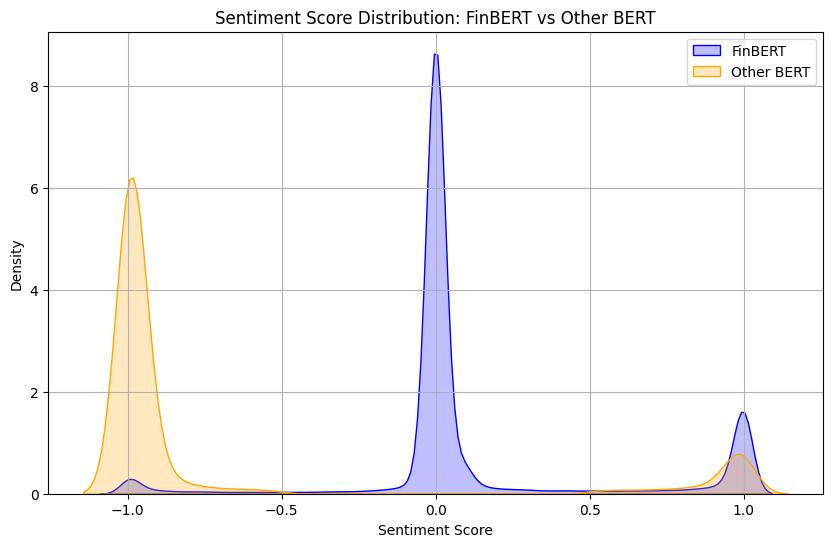

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE
plt.figure(figsize=(10,6))
sns.kdeplot(df["finbert_score"], label="FinBERT", color="blue", fill=True)
sns.kdeplot(df["other_bert_score"], label="Other BERT", color="orange", fill=True)
plt.title("Sentiment Score Distribution: FinBERT vs Other BERT")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# desc for finBERT and other BERT
finbert_stats = df["finbert_score"].describe()
other_bert_stats = df["other_bert_score"].describe()

comparison = pd.DataFrame({
    "FinBERT": finbert_stats,
    "Other BERT": other_bert_stats
})

print(comparison)

             FinBERT     Other BERT
count  513285.000000  513285.000000
mean        0.123205      -0.697947
std         0.418386       0.664344
min        -1.000000      -0.999826
25%        -0.000445      -0.996138
50%        -0.000004      -0.988183
75%         0.031765      -0.948070
max         1.000000       0.999884


- FinBERT has a mean of +0.071, which is roughly neutral and slightly positive, reasonable since FinBERT is specifically trained on financial data.

- Other BERT's mean of -0.75 is super negative, which doesn't seem very reasonable -- it basically predicts all tweets as negative!

- Other BERT's 25%, 50%, and 75% are all negative, suggesting that it gives most of its tweets very negative scores.

- FinBERT's score is very close to 0, which is more in line with the short text and lots of neutral noise that characterizes tweets.